In [136]:
%matplotlib inline
from multisim.multisim import *
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
import pfilter.pfilter as pf
from scipy.stats import norm
import seaborn as sns

In [137]:
# set up system
nsteps = 500

tfaulton  = 0.1
tfaultoff = 0.3
tend      = 3.0

time   = np.linspace(0,tend,nsteps)
step   = time[1]

time_1 = [t for t in time if t < tfaulton]
time_2 = [t for t in time if t > tfaulton and t < tfaultoff]
time_3 = [t for t in time if t > tfaultoff]


# We'll use these indexes to apply and remove the fault on the time loop
time_on_idx  = len(time_1)
time_off_idx = len(time_1) + len(time_2)


# create system: this can be a file that we parse
dsystem = System()
dsystem.silent()

for i in range(2):
    dsystem.addbus(i)

dsystem.buses[0].setvinit(cmath.rect(1.04, 0))
dsystem.buses[1].setvinit(cmath.rect(1.01613, (np.pi/180.0)*-3.3252))

dsystem.addbranch(0, 1, 0.0001, 0.0576)
dsystem.createYbusReal()

gen1 = GenCLS(0, 5.0, 1.0)
gen1.setinitpow(1.06496, 0.45996)

load = ZLoad(1, (1.03123 + 1j*-0.37616))

dsystem.adddevice(gen1)

dsystem.addload(load)

In [138]:
#######################################
#######################################
##  FUNCTIONS FOR FILTERING         ###
##                                  ###
#######################################
#######################################

# theta = [H xd eqp], u = [pm eqp]
# assume we have good grip on states
def prior(x, w, mean, prior_var):
    size = len(w)
    for i in range(size):
        x[0,i] = mean[0] #+ mean[0]*np.random.normal(0, prior_var)
        x[1,i] = mean[1] #+ mean[1]*np.random.normal(0, prior_var)

def measurement(theta, x, y, volt, meas_var):
    size = y.shape[1]
    for i in range(size):

        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = theta[3]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        delta = xold[0]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
        
        i_d = (eqp - vq)/xd
        i_q = vd/xd
        
        y[0, i] = i_q# + np.random.normal(0, meas_var)
        y[1, i] = i_d# + np.random.normal(0, meas_var)
        
        #y[0, i] = np.sin(delta)*i_d + np.cos(delta)*i_q  #+ np.random.normal(0, meas_var)
        #y[1, i] = -np.cos(delta)*i_d + np.sin(delta)*i_q #+ np.random.normal(0, meas_var)

def likelihood(w, y, meas_curr, meas_var):
    size = y.shape[1]
    for i in range(size):
        w[i] = norm.pdf(y[0, i] - meas_curr[0], 0, meas_var)*norm.pdf(y[1, i] - meas_curr[1], 0, meas_var)
        
        
def non_funct(x, xold, vt, angle, theta, h):
    
    F = np.zeros(2)
    
    H   = theta[0]
    xd  = theta[1]
    eqp = theta[2]
    pm  = theta[3]

    vd = vt*np.sin(x[0] - angle)
    vq = vt*np.cos(x[0] - angle)
    
    F[0] =  x[0] - xold[0] + h*(2*np.pi*60.0*x[1])
    F[1] =  x[1] - xold[1] - h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H)
        
    return F
        
def propagate(theta, x, volt, h):
    
    size = x.shape[1]
    for i in range(size):
                
        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = theta[3]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
                
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*xold[1])
        x[1, i] = x[1, i] + h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H)
         
        #sol = optimize.root(non_funct, xold, args = (xold, vt, angle, theta, h))
        #x[0, i] = sol.x[0]
        #x[1, i] = sol.x[1]
            
        # question: how we determine the noise?
        #x[0, i] += np.random.normal(0, 0.1)
        #x[1, i] += np.random.normal(0, 0.01)

In [139]:
#######################################
#######################################
##  FUNCTIONS FOR CONTROL           ###
##                                  ###
#######################################
#######################################

def propagate_control(theta, x, u, volt, h):
    
    size = x.shape[1]
    for i in range(size):
                
        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = u[0, i]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
                
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*xold[1]) # + np.random.normal(0, 0.01, 1)
        x[1, i] = x[1, i] + h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H) #+ np.random.normal(0, 0.001, 1)
        
def propagate_u(u, var):
    
    size = u.shape[1]
    for i in range(size):
        u[0, i] = u[0, i] + np.random.uniform(-var, var, 1)
        
def setpoint(x, s):
    
    size = x.shape[1]
    for i in range(size):
        s[0, i] = x[1, i] 
        
def weight_set(w, s, setpoint, set_var):
    size = s.shape[1]
    for i in range(size):
        w[i] = w[i]*norm.pdf(s[0, i] - setpoint, 0, set_var)
    

In [140]:
# INITIALIZE SYSTEM AND PARTICLE FILTER
# Solve system
x = initialize_system(dsystem)

print x

# allocate array for trajectory plus steady-state solutions
trajectory = np.zeros((len(x), len(time)))
trajectory[:,0] = np.copy(x)

# initialize particle filter and priors
nparticles = 1
meas_noise = 3e-3
model_var = 0.01
meas_var  = 8e-2
prior_var = 0.1

# model parametes
theta = [gen1.H, gen1.xd, gen1.e_q, gen1.p_m]

# init cloud 
x_dim = 2
y_dim = 2
cl = pf.cloud(nparticles, x_dim, y_dim)
exp_n = np.zeros((x_dim, len(time)))

# prior sampling
meas_volt = x[6:8]#  + np.random.normal(0, meas_noise, 2)
meas_curr = x[4:6]#  + np.random.normal(0, meas_noise, 2)


prior(cl.x, cl.w, [x[0], x[1]], prior_var = 0.1)


measurement(theta, cl.x, cl.y, meas_volt, meas_var)

likelihood(cl.w, cl.y, meas_curr, meas_var)
pf.normalize(cl.w)

exp_n[0, 0] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
exp_n[1, 0] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 

1.80158210262 1.06496
[  6.04546855e-01  -9.28962602e-27   8.55670134e-01   5.91124878e-01
   5.91124878e-01   9.45911968e-01   1.04000000e+00   0.00000000e+00
   1.01441925e+00  -5.89387053e-02]


In [141]:
# CREATE CONTROL PARTICLE FILTER

npart_mpc = 100
L = 50
mpc_pf = pf.cloud_control(npart_mpc, 2, 1, 1)

In [142]:
for i in range(len(time) - 1):
    
    ############################
    ##### SIMULATION LOOP  #####
    ############################
    
    if (i == time_on_idx):
        fault_id = dsystem.applyBusFault(1, 0.01)
        x = solve_steady_system(trajectory[:, i], dsystem)
        
    elif (i == time_off_idx):
        dsystem.removeBusFault(fault_id)
        x = solve_steady_system(trajectory[:, i], dsystem)
        
    else:
        x = trajectory[:, i]
        
    trajectory[:, i + 1] = propagate_system(x, dsystem, step)
        
    # GENERATE MEASUREMENTS
    
    meas_volt = trajectory[6:8, i + 1]#  + np.random.normal(0, meas_noise, 2)
    meas_curr = trajectory[4:6, i + 1]#  + np.random.normal(0, meas_noise, 2)
        
    ############################
    ##### FILTERING LOOP   #####
    ############################
    
    cl.x = pf.resample_systematic(cl.w, cl.x)
    cl.w = (1.0/nparticles)*np.ones(nparticles)
    propagate(theta, cl.x, meas_volt, step)

    measurement(theta, cl.x, cl.y, meas_volt, meas_var)
    likelihood(cl.w, cl.y, meas_curr, meas_var)
    pf.normalize(cl.w)
    exp_n[0, i + 1] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
    exp_n[1, i + 1] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 
    
    ############################
    ##### CONTROL   LOOP   #####
    ############################
    
    if (0):
   
    # update states of particle cloud
        for j in range(npart_mpc):
            mpc_pf.x[:, j]  = trajectory[0:2, i + 1]
            mpc_pf.u[0, j]  = dsystem.devices[0].p_m + np.random.uniform(-0.2, 0.2, 1)
            mpc_pf.uk[0, j] = mpc_pf.u[0, j]
        
    # propagate for horizon
        for j in range(L):
            
            mpc_pf.x, mpc_pf.u, mpc_pf.uk = pf.resample_systematic_control(mpc_pf.w, mpc_pf.x, 
                mpc_pf.u, mpc_pf.uk)
            mpc_pf.w = (1.0/npart_mpc)*np.ones(npart_mpc)
            
            propagate_control(theta, mpc_pf.x, mpc_pf.uk, meas_volt, step)
        
            setpoint(mpc_pf.x, mpc_pf.s)
            weight_set(mpc_pf.w, mpc_pf.s, 0.0, 0.01)
            pf.normalize(mpc_pf.w)
            propagate_u(mpc_pf.uk, 0.1)
                
        # calculate control
        u_set = np.average(mpc_pf.u[0,:], axis = 0, weights=mpc_pf.w)
        print "At time %g apply control %f" % (time[i], u_set)
    
        dsystem.devices[0].p_m = u_set
        
        print pf.neff(mpc_pf.w)

At time 0 apply control 1.073717
99.93194658
At time 0.0601202 apply control 1.058155
99.9102727901
>>>APPLYING FAULT at bus: 1, z: 0.01.
Solve steady state
At time 0.12024 apply control 0.862571
97.8814042075
At time 0.180361 apply control 0.735829
99.3123714372
At time 0.240481 apply control 0.566576
99.5194522271
<<<REMOVING FAULT at bus: 1, z: 0.01.
Solve steady state
At time 0.300601 apply control 0.544667
97.6056594646
At time 0.360721 apply control 0.573374
98.9671040055
At time 0.420842 apply control 0.606880
98.9962014158
At time 0.480962 apply control 0.637844
99.4266308863
At time 0.541082 apply control 0.742599
99.8748778237
At time 0.601202 apply control 0.826368
99.924127045
At time 0.661323 apply control 0.904448
99.8729591333
At time 0.721443 apply control 0.942511
99.8728659521
At time 0.781563 apply control 0.962604
99.773874561
At time 0.841683 apply control 1.012148
99.7414156386
At time 0.901804 apply control 1.068273
99.7837972149
At time 0.961924 apply control 1.

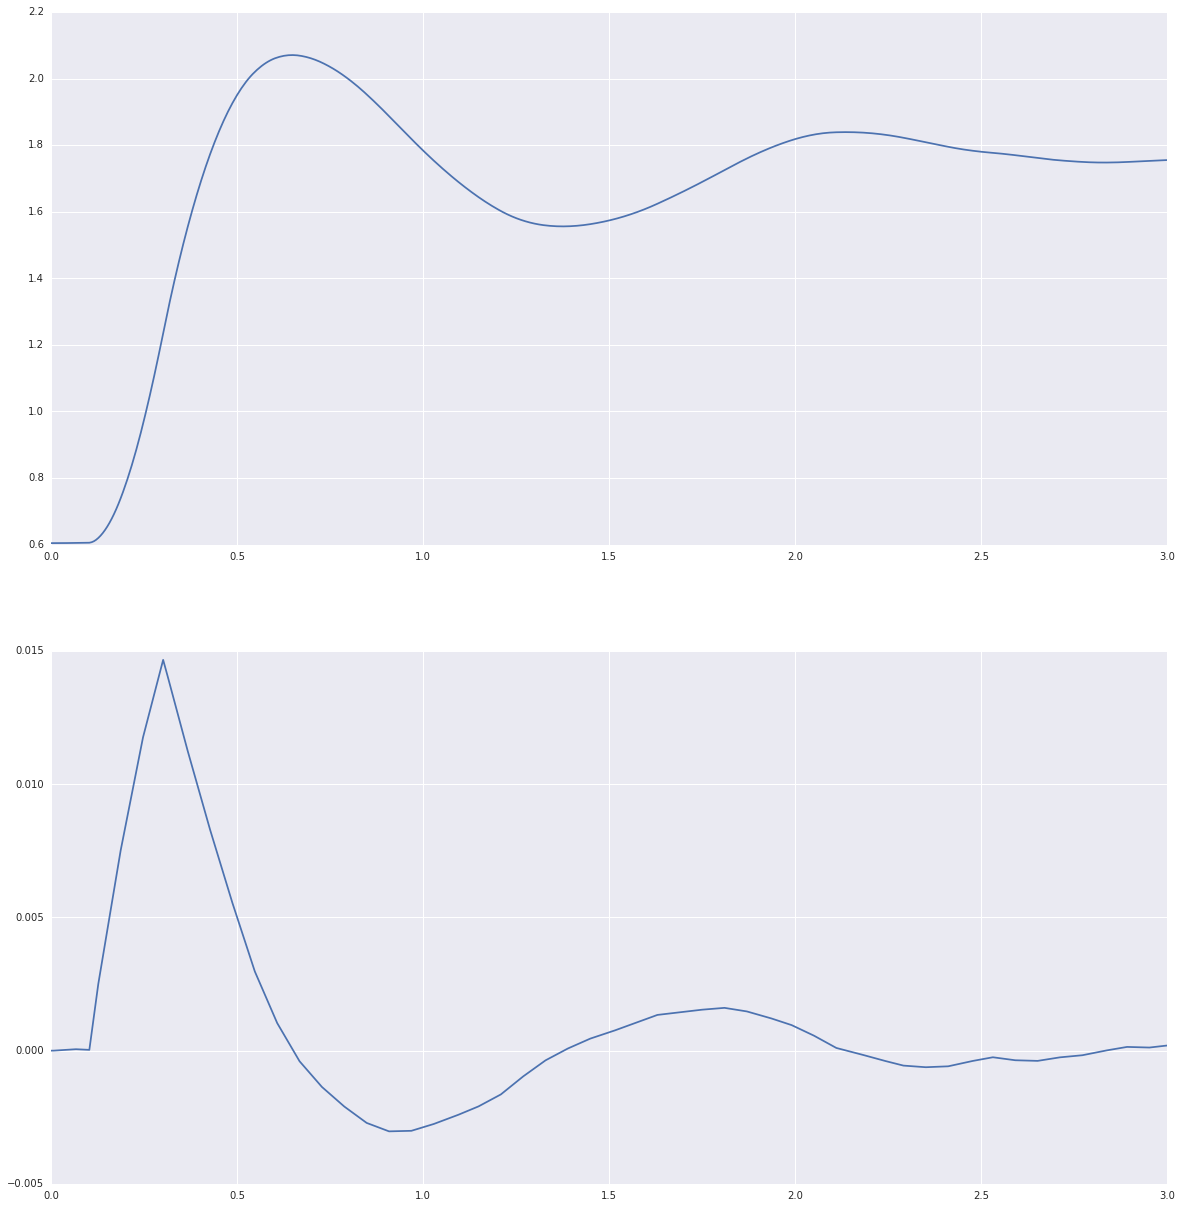

In [143]:
f, axes = plt.subplots(2, 1, figsize=(20, 21))


#axes[0].plot(time[:-1], exp_n[0,:-1])
axes[0].plot(time, trajectory[0,:])
#axes[1].plot(time[:], exp_n[1,:])
axes[1].plot(time[:], trajectory[1,:])

#axes[0].plot(time[:-1], exp_n[0,:-1])
#axes[0].plot(time, trajectory[0,:])
#axes[1].plot(time[40:60], exp_n[1,40:60])
#axes[1].plot(time[40:60], trajectory[1,40:60])

#axes[0].plot(exp_n[1,40:100])
#axes[0].plot(trajectory[1,41:101])


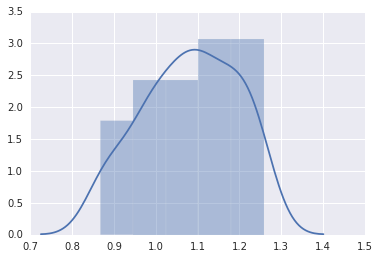

In [144]:
sns.distplot(mpc_pf.u)